# Scraping MTGStocks for Magic: The Gathering Card Prices

## Import Libraries

In [2]:
import pandas as pd 
from pandas import json_normalize
import glob 
from bs4 import BeautifulSoup 
import requests 
import datetime 
import time 
import json 
import csv
import matplotlib.pyplot as plt 
import math

## Downloading HTM files from MTGStocks.com and retrieving the link of every Final Fantasy Card and storing it into a dictionary.
### In order to retrieve the link of 600+ individual cards from the Universes Beyond: Final Fantasy set, I had to manually download all thirteen pages <a href="https://www.mtgstocks.com/sets/2197-universes-beyond-final-fantasy">from the MTGStocks Universes Beyond: Final Fantasy landing page.</a>
<img src="https://raw.githubusercontent.com/brandonmalave/imagehost/refs/heads/main/FFMTG_SavePageAs.png">

In [ ]:
paths = glob.glob("../data/mtgcards/*.htm") # Store all of the file paths into the variable "paths"
paths

### Parsing through each file using for loops and storing the card name and link into a list of dictionaries.

In [ ]:
for path in paths: # Use a for loop to read .htm files stored in the "paths" variable.
    print(f"Processing {path}...") # Track the processing of each HTM files.
    with open(path, "r") as page:
        soup = BeautifulSoup(page, "html.parser")
        
for path in paths: # Loop through all HTM file paths.
    with open(path, "r") as page: # Open each HTM file.
            soup = BeautifulSoup(page, "html.parser") # Parse the HTM file using BeautifulSoup.
            for table in soup.find_all("table"): # Use the find_all function to locate the table where our data is hiding.
                for a in table.find_all("a", href=True): # Find all <a> tags that have an href attribute.
                    href = a["href"] # Extract the link from the 'href' attribute.
                    text = a.get_text(strip=True) # Extract text from the link, removing leading/trailing spaces.
                    card_links.append({ # Store both the name and the link in a dictionary.
                        "card_name": text, # The card name.
                        "card_link": href # The card link.
                    })

In [ ]:
card_links # Call the variable to make sure it looks right

### Separating the card id from the link

In [ ]:
card_ids = [] # Create an empty list to store the ids of every card
card_ids = [link["card_link"].split("/prints/")[1].split("-")[0] for link in card_links]
card_ids # Call list to make sure everything looks good.

# Finally, create a list of links using every cards unique id to gain access their price history via the MTGStocks API json dictionaries.

In [ ]:
card_api_links = [] # Create an empty list of links for the api.
for card_id in card_ids: # Loop through the list of card ids.
    link = f"https://api.mtgstocks.com/prints/{card_id}/prices/tcgplayer" # Attatch code to the api link.
    card_api_links.append(link) # Store each link into the card_api_links list.

In [ ]:
card_api_links # Call card_api_links to make sure everything looks good.

### Make sure there is an equal amount of ids and links

In [ ]:
len(card_api_links) # Returns the length of the card_api_links list

In [ ]:
len(card_ids) #Returns the length of the card_ids list

### Using pandas to create a dataframe from the api links

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

test_url = "https://api.mtgstocks.com/prints/127325/prices/tcgplayer"

response = requests.get(test_url, headers = headers)
ff_card_data = response.json()
ff_card_data


In [ ]:
ff_card_data.keys()

### Creating a new dataframe for each of the price points 'low', 'avg', foil', 'market', and 'market_foil'
### Merge all of the dataframes into a single dataframe on 'timestamp'

In [ ]:
ff_df_low = pd.DataFrame(ff_card_data["low"], columns=["timestamp", "low"])
ff_df_avg = pd.DataFrame(ff_card_data["avg"], columns=["timestamp", "avg"])
ff_df_foil = pd.DataFrame(ff_card_data["foil"], columns=["timestamp", "foil"])
ff_df_market = pd.DataFrame(ff_card_data["market"], columns=["timestamp", "market"])
ff_df_market_foil = pd.DataFrame(ff_card_data["market_foil"], columns=["timestamp", "market_foil"])

ff_merged_df = ff_df_low.merge(ff_df_avg, on="timestamp").merge(ff_df_foil, on="timestamp").merge(ff_df_market, on="timestamp").merge(ff_df_market_foil)

In [ ]:
ff_merged_df # Return the dataframe to make sure everything looks good.

### Converting Epoch time to datetime (seriously, why are we using epoch time in the big 25?)

In [ ]:
ff_merged_df["date"] = pd.to_datetime(ff_merged_df["timestamp"], unit="ms") # Create a new column in the dataframe that converts epoch time to datetime.

In [ ]:
ff_new_df = ff_merged_df.drop("timestamp", axis=1) # Create a new data frame that removes the 'timestamp' column from the merged dataframe 
ff_new_df

<img src="https://raw.githubusercontent.com/brandonmalave/imagehost/refs/heads/main/sepiroth%2C%20fabled%20soldier.jpg">

In [ ]:
ff_new_df.plot(x='date', y='avg', kind='line', title='Final Fantasy: Sephiroth, Fabled SOLDIER (Borderless)')
plt.show()

### Instead of repeating this process with the Ixal Standard Set, I will compare the most expensive card in this set to the most expensive card of the Final Fantasy set.

In [ ]:
test_url = "https://api.mtgstocks.com/prints/35596/prices/tcgplayer"

response = requests.get(test_url, headers = headers)
ixalan_card_data = response.json()

if isinstance(ixalan_card_data, dict):
    # if there's a "data" or similar key that holds the prices
    for key in ['data', 'prices', 'values', 'tcgplayer']:
        if key in ixalan_card_data:
            ixalan_card_data = ixalan_card_data[key]
            break

# Ensure it's a list of records before making a DataFrame
if isinstance(ixalan_card_data, list):
    ixalan_df = pd.json_normalize(ixalan_card_data)
else:
    ixalan_df = pd.DataFrame([ixalan_card_data])

<img src="https://raw.githubusercontent.com/brandonmalave/imagehost/refs/heads/main/revel%20in%20riches.jpg">

In [ ]:
ixalan_df_low = pd.DataFrame(ixalan_card_data["low"], columns=["timestamp", "low"])
ixalan_df_avg = pd.DataFrame(ixalan_card_data["avg"], columns=["timestamp", "avg"])
ixalan_df_foil = pd.DataFrame(ixalan_card_data["foil"], columns=["timestamp", "foil"])
ixalan_df_market = pd.DataFrame(ixalan_card_data["market"], columns=["timestamp", "market"])
ixalan_df_market_foil = pd.DataFrame(ixalan_card_data["market_foil"], columns=["timestamp", "market_foil"])

ixalan_merged_df = ixalan_df_low.merge(ixalan_df_avg, on="timestamp").merge(ixalan_df_foil, on="timestamp").merge(ixalan_df_market, on="timestamp").merge(ixalan_df_market_foil)

ixalan_merged_df["date"] = pd.to_datetime(ixalan_merged_df["timestamp"], unit="ms")

ixalan_new_df = ixalan_merged_df.drop("timestamp", axis=1)

ixalan_new_df.plot(x='date', y='avg', kind='line', title='Ixalan: Revel in Riches')
plt.show()

### Closing Notes
- The next step in this data investigation would be to automate this process, prehaps by creating a function where I could just input a card id and it will return a dataframe and line graph, properly labled by card name.
- Off the top of my head, this can be done a couple ways. Using a for loop to make a dictionary that includes each of the 644 unique card links in the card_api_links list, and all of the relevant data obtained by parseing the json.
### ChatGPT Disclaimer
- I used ChatGPT to troubleshoot some errors, like when I used the 'if isinstance' function when parsing through the api links. As far as I remember, we were not taught this in class, so I am not sure what this function actually does, but the fix provided got me through a hiccup I was encountering. Before I was returning an error "ValueError: All arrays must be of the same length," when I stored the response.json() into a dataframe. I was not sure how to fix it and resorted to chatGPT.
### Further Data Analysis
- Some things to consider: Is it possible to use the complete list of cards per set to chart a general price trend across all cards all at once? Do this with the Ixalan Standard set and compare the two if possible
- Excluding market foils and foils because those are more of a premium product for collectors, and holds no real value to the average joe playing the game and buying cards requried to complete their decks.
- Creating a csv that is a complete database of every single card I used in this analysis.

# Part 2: Scraping Dynamically + Data Visualization
- Inspecting the network of the website under the sources tab, I was able to find the link for the API for the page containing links to every single card within a set on the dynamic web page at https://api.mtgstocks.com/card_sets/280.
- With this, I can now scrape and create a list of API links for every individual card in a set without manually downloading the htm files like I did before.

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

set_id = 280 #The Ixal set ID. Change ID as needed for whichever set you want to scrape.
api_link = f"https://api.mtgstocks.com/card_sets/{set_id}"

response = requests.get(api_link, headers=headers) # Make the GET request

data = response.json() # Parse JSON

cards_list = data.get("prints") or data.get("cards") or data.get("data")

rows = []
for c in cards_list:
    card_id = c.get("id") or c.get("print_id")
    name = c.get("name")
    link = c.get("link") or f"https://mtgstocks.com/prints/{card_id}"
    rows.append({
        "card_id": card_id,
        "name": name,
        "link": link
    })

df_cards = pd.DataFrame(rows)
print(df_cards.head())

In [ ]:
df = pd.DataFrame({'link': link})

df['card_id'] = df['link'].str.split('/').str[4].astype(int)
print(df)

In [ ]:
card_api_links = [] # Create an empty list of links for the api.
for card_id in df['card_id']: # Loop through the list of card ids.
    link = f"https://api.mtgstocks.com/prints/{card_id}/prices/tcgplayer" # Attatch card_id to the API link.
    card_api_links.append(link) # Store each link into the card_api_links list.
card_api_links

## Creating a complete dataset from list of API links
- Now that we can now dynamically scrape MTGStocks, the final step is to create a complete dataset using data from each individual card in a single dataframe

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}

final_df = pd.DataFrame()

for card_api_link in card_api_links:
    try:
        response = requests.get(card_api_link, headers = headers)
        card_data = response.json()
        
        time.sleep(2)
        print ("Politely Scraping: Waiting two seconds...")
        
        market_data = pd.DataFrame(card_data["market"], columns=["timestamp", "market"])
        market_data["date"] = pd.to_datetime(market_data["timestamp"], unit="ms")
        market_data["card ID"] = card_api_link.split("/")[4]
        new_market_data = market_data.drop("timestamp", axis=1)
    
    except KeyError: ## Some cards are exclusively foil, so they only have a 'market foil' key, not a 'market key' causing the scrape to return an error.
        print(f" Missing Key 'market': KeyError encountered while processing {card_api_link}") 
        continue  #continue the scrape should a keyerror occur.
    except json.JSONDecodeError: ## I ran into this error when I forgot to put a timer on the scrape, crashing the website and its API. 
        print(f"Invalid JSON returned from {card_api_link}")
        print("Raw response:", response.text[:200])
        continue

    final_df = pd.concat([final_df, new_market_data], ignore_index=True)

final_df.to_csv("mtg_price_data_ixal_market.csv", index=False) 

## Visualization 
- Finally, it is time to chart the data findings
- Because the dataframe contains data for every single card in a set, card ids and dates repeat, but with groupby I can group rows by their unique ids to preform my analysis.

In [3]:
ixal_df = pd.read_csv("../notebooks/mtg_price_data_ixal_market.csv")

In [4]:
ixal_df

,market,date,card ID
0,0.26,2017-11-24,35582
1,0.24,2017-11-25,35582
2,0.23,2017-11-26,35582
3,0.21,2017-11-27,35582
4,0.23,2017-11-28,35582
...,...,...,...
883037,0.16,2025-12-06,35957
883038,0.16,2025-12-07,35957
883039,0.16,2025-12-08,35957
883040,0.16,2025-12-09,35957


## Calculating the yearly average price change
- Now that I have a database for the price of every single card in a set, I can find the average percent change in price for all of the cards.

In [5]:
df = ixal_df.sort_values(['card ID', 'date'])
df['date'] = pd.to_datetime(df['date'])

df['pct_change'] = df.groupby('card ID')['market'].pct_change() * 100

df['year'] = df['date'].dt.to_period('Y')  

yearly_avg = df.groupby('year')['pct_change'].mean().reset_index()
yearly_avg['year'] = yearly_avg['year'].dt.to_timestamp()

In [6]:
yearly_prices = df.groupby(['card ID', df['date'].dt.to_period('Y')])['market'].first().reset_index()
yearly_prices['date'] = yearly_prices['date'].dt.to_timestamp()

yearly_prices['pct_change'] = yearly_prices.groupby('card ID')['market'].pct_change() * 100

yearly_avg = yearly_prices.groupby('date')['pct_change'].mean().reset_index()

## Plotting the average yearly percent change using Matplotlib
- The moment all of this work for! The visualization of my findings.

<img src="https://media.wizards.com/2023/images/daily/5UK4owRxnQy.jpg">

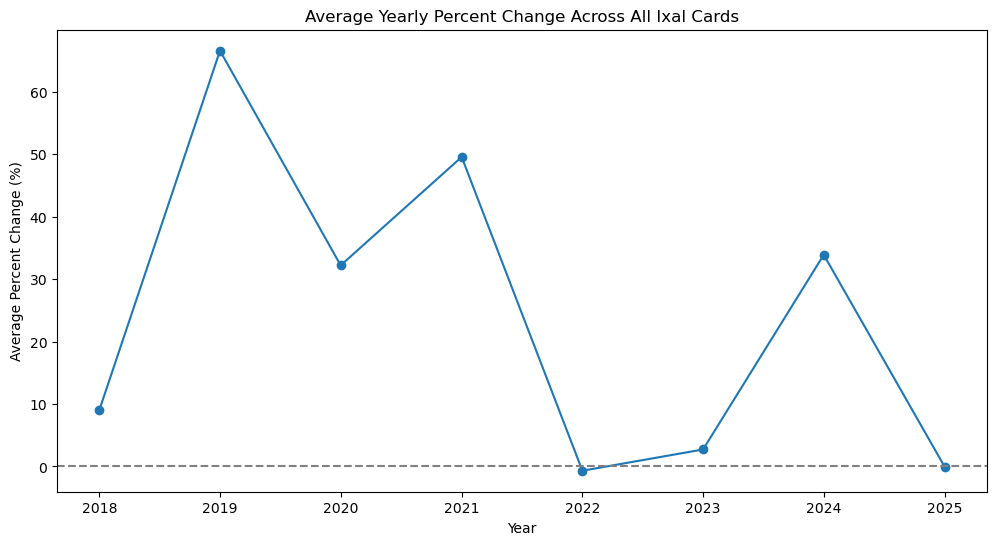

In [7]:
plt.figure(figsize=(12,6))
plt.plot(yearly_avg['date'], yearly_avg['pct_change'], marker='o', linestyle='-')
plt.axhline(0, color='gray', linestyle='--') 
plt.title("Average Yearly Percent Change Across All Ixal Cards")
plt.xlabel("Year")
plt.ylabel("Average Percent Change (%)")
plt.show()

## Generating a line graph of monthly price changes for the Universes Beyond Final Fantasy Set
- I already ran the scraper for the Universes Beyond: Final Fantasy Set and stored the csv locally.
- The Final Fantasy set will be graphed by the monthly percent change average, because it is only several months old compared to the Ixal set which has been around since 2018.

In [8]:
ff_df = pd.read_csv("../notebooks/mtg_price_data_market.csv")
ff_df

,market,date,card ID
0,2.00,2025-05-16,128287
1,1.84,2025-05-17,128287
2,1.85,2025-05-18,128287
3,1.84,2025-05-19,128287
4,1.83,2025-05-20,128287
...,...,...,...
118205,72.11,2025-12-06,128443
118206,72.10,2025-12-07,128443
118207,72.74,2025-12-08,128443
118208,72.61,2025-12-09,128443


In [9]:
df = ff_df.sort_values(['card ID', 'date'])
df['date'] = pd.to_datetime(df['date'])

df['pct_change'] = df.groupby('card ID')['market'].pct_change() * 100

df['month'] = df['date'].dt.to_period('M')

monthly_avg = df.groupby('month')['pct_change'].mean().reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()  

In [10]:
monthly_prices = df.groupby(['card ID', df['date'].dt.to_period('M')])['market'].first().reset_index()
monthly_prices['date'] = monthly_prices['date'].dt.to_timestamp()
monthly_prices['pct_change'] = monthly_prices.groupby('card ID')['market'].pct_change() * 100
monthly_avg = monthly_prices.groupby('date')['pct_change'].mean().reset_index()

<img src = "https://images.ctfassets.net/s5n2t79q9icq/YuJejk2XlEqXfTNCREX8k/56117e86f47e2ce11de715f0515ccce6/FIN_Key_Art_960x540.png">

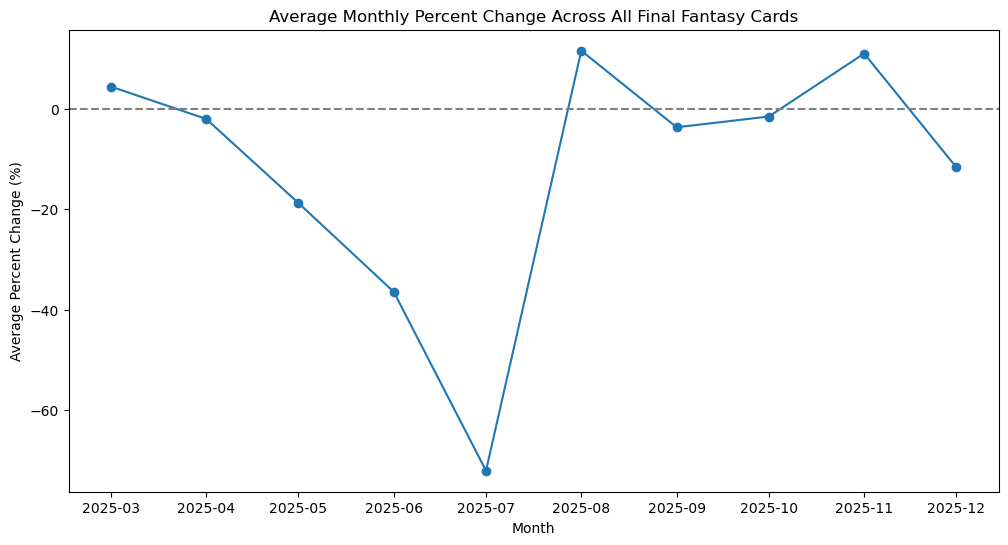

In [11]:
plt.figure(figsize=(12,6))
plt.plot(monthly_avg['date'], monthly_avg['pct_change'], marker='o', linestyle='-')
plt.axhline(0, color='gray', linestyle='--')  # baseline
plt.title("Average Monthly Percent Change Across All Final Fantasy Cards")
plt.xlabel("Month")
plt.ylabel("Average Percent Change (%)")
plt.show()

# Findings
- The Magic: The Gathering (MTG) market reacted to Hasbros decision to start purchasing licenses for franchises of popular culture for their Universes Beyond sets exactly how I imagined. Much like the novelty of collectible baseball cards, there is now a collectors market forming around Magic: The Gathering and drastic increases in individual card prices across every card ever printed.
- For the Ixal Set, the yearly average price across all cards increased every single year since their release until 2022 where it stabilized. The prices began to increase yet again in 2022-2024, around the same time as the rollout of Universes Beyond. 
- On the contrary, the price of MTG Final Fantasy cards dropped significantly from the pre release preiod (March-July), and on official release (July-August) the prices exploded upwards. Secondary Market are captilizing on the release hype with significant price hikes for new sets. Despite the significant drop, these cards are still more expensive than non-licensed cards because the starting price is higher. The fandom premium is real.

# Notes
- I could do this for every single set that exists within Magic: The Gathering, but depending on the amount of cards within a set, an ethical scrape could take anywhere from 20-35 minutes per set. For the purposes of my capstone, I think this is just enough data to drive my main point home.